# CRACKS DETECTION

In [75]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from PIL import Image
import os, sys
import sklearn.model_selection as ms

In [76]:
! ls data

Negative
Positive


In [77]:
root_dir = 'data'

#  Image Sample

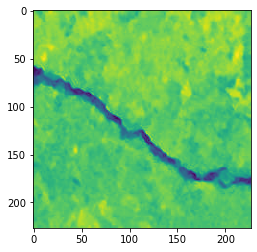

In [5]:
img_dir = 'data/Positive/00027.jpg'
image =  plt.imread(img_dir)
image = Image.open(img_dir).convert("L")
image = np.asarray(image)
plt.imshow(image)


# Comparison Between Coloured And Grayscale Images

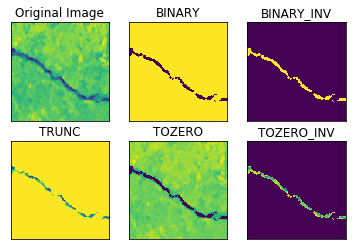

In Grayscale


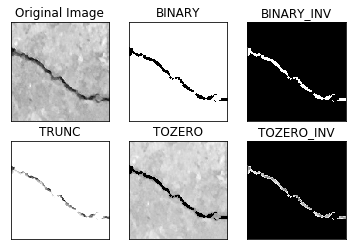

In [6]:
img = cv2.imread(img_dir,0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

print('In Grayscale')
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

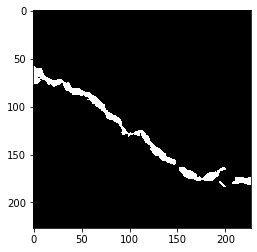

In [7]:
plt.imshow(thresh2, 'gray')

# Functions For Processing Images And Creating Data

In [73]:
def process_image(image):
    ret,bi_inv = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
    #plt.imshow(bi_inv, 'gray')
    return bi_inv, image

In [86]:
def create_dataset(root_dir, ratio=0.7):
    ext = '.jpg'
    positive_samples = [[name, 1] for name in os.listdir(os.path.join(root_dir, 'Positive'))]
    negative_samples = [[name, 0] for name in os.listdir(os.path.join(root_dir, 'Negative'))]
    full_data = np.array(positive_samples + negative_samples)
    x_train, x_test, \
    y_train, y_test = ms.train_test_split(full_data[:, 0],
                                          full_data[:, 1], 
                                          train_size=ratio, 
                                          random_state=42)
    
    x_val, x_test, \
    y_val, y_test = ms.train_test_split(x_test,
                                          y_test, 
                                          train_size=0.5, 
                                          random_state=42)
    
    train_colored_data, train_bi_inv_data = [], []
    val_colored_data, val_bi_inv_data =[],[]
    test_colored_data, test_bi_inv_data =[],[]

    for i in range(len(x_train)):
        pn = 'Positive' if y_train[i]=='1' else 'Negative'
        fullpath = os.path.join(root_dir, pn, x_train[i])
        image = cv2.imread(fullpath, 0)
        assert image is not None, fullpath
        bi_inv, colored_img = process_image(image)
        train_colored_data.append(colored_img)
        train_bi_inv_data.append(bi_inv)  
        
    for i in range(len(x_val)):
        pn = 'Positive' if y_val[i]=='1' else 'Negative'
        fullpath = os.path.join(root_dir, pn, x_val[i])
        image = cv2.imread(fullpath, 0)
        bi_inv, colored_img = process_image(image)
        val_colored_data.append(colored_img)
        val_bi_inv_data.append(bi_inv) 
    
    for i in range(len(x_test)):
        pn = 'Positive' if y_test[i]=='1' else 'Negative'
        fullpath = os.path.join(root_dir, pn, x_test[i])
        image = cv2.imread(fullpath, 0)
        bi_inv, colored_img = process_image(image)
        test_colored_data.append(colored_img)
        test_bi_inv_data.append(bi_inv) 
    

    return x_train, x_test, x_val, y_train, y_val, y_test, \
            np.array(train_colored_data).reshape(((len(train_colored_data), 227, 227, 1))), \
            np.array(train_bi_inv_data).reshape(((len(train_bi_inv_data), 227, 227, 1))), \
            np.array(val_colored_data).reshape(((len(val_colored_data), 227, 227, 1))), \
            np.array(val_bi_inv_data).reshape(((len(val_bi_inv_data), 227, 227, 1))), \
            np.array(test_colored_data).reshape(((len(test_colored_data), 227, 227, 1))), \
            np.array(test_bi_inv_data).reshape(((len(test_bi_inv_data), 227, 227, 1)))
    
    
(x_train, x_test, x_val, y_train, y_val, y_test,
train_colored_data, train_bi_inv_data,
val_colored_data, val_bi_inv_data,
test_colored_data, test_bi_inv_data)= create_dataset(root_dir, ratio=0.7)

# Training Data : 3000 Images

In [60]:
! pip install keras

  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl


# Model Creation (Convolutional Neural Networks)

In [62]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model


In [63]:
input_shape = (227, 227, 1)
Wh = 3
Ww = 3

In [64]:
model = Sequential()
model.add(Conv2D(input_shape=input_shape , data_format="channels_last", kernel_size=(Wh,Ww), filters=32, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [94]:
batch_size = 250
epochs = 30
model_name = 'crack_detector_v1.h5'

#  Training Process

In [96]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# x_train, x_test, y_train, y_test, \
# train_colored_data, train_bi_inv_data, \
# test_colored_data, test_bi_inv_data

model.fit(train_bi_inv_data, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(val_bi_inv_data, y_val))
os.makedirs('./weights', 777, exist_ok=True)
os.makedirs('./models', 777, exist_ok=True)
model.save('./weights/'+ model_name)
model.save_weights('./models/'+ model_name)


Train on 28000 samples, validate on 6000 samples
Epoch 1/30
28000/28000 [==============================] - 490s 18ms/step - loss: 0.0353 - accuracy: 0.9970 - val_loss: 0.1626 - val_accuracy: 0.9832
Epoch 2/30
28000/28000 [==============================] - 499s 18ms/step - loss: 0.0157 - accuracy: 0.9975 - val_loss: 0.2756 - val_accuracy: 0.9793
Epoch 3/30
28000/28000 [==============================] - 544s 19ms/step - loss: 0.0233 - accuracy: 0.9972 - val_loss: 0.1774 - val_accuracy: 0.9812
Epoch 4/30
28000/28000 [==============================] - 505s 18ms/step - loss: 0.0145 - accuracy: 0.9976 - val_loss: 0.1620 - val_accuracy: 0.9850
Epoch 5/30
28000/28000 [==============================] - 482s 17ms/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 0.2388 - val_accuracy: 0.9822
Epoch 6/30
28000/28000 [==============================] - 482s 17ms/step - loss: 0.0244 - accuracy: 0.9979 - val_loss: 0.8688 - val_accuracy: 0.9720
Epoch 7/30
28000/28000 [==============================] -

# Accuracy And Loss 

In [19]:
score=model.evaluate(final_test_inv, test_labels)
print('Final Accuracy : ', score[1]*100, "%" )
print('Final Loss : ', score[0])

400/400 [==============================] - 13s 32ms/step
Final Accuracy :  97.5 %
Final Loss :  0.3562050382560025


#  Image Predictor (Functions)

In [20]:
def predict_image_util(final_pred_inv):
    img_test = (final_pred_inv[0].reshape((1, 227, 227, 1)))  
    raw_predicted_label = model.predict(img_test, batch_size=None, verbose=0, steps=None)[0][0]
    
    predicted_label=1;    
    if(raw_predicted_label<0.8):
        predicted_label=0
        
    predicted_label_str='Crack'    
    if(predicted_label==0):
        predicted_label_str='No Crack'
        
    print('Raw Predicted Label(Numeric): '+str(raw_predicted_label))
    print('\nPredicted Label : '+predicted_label_str)    

In [21]:
from_data_dir = 'original_data/'  #Directory

def predict_image2(type_, num):
    
    pred_data_colr_, pred_data_inv_ = create_data(from_data_dir, type_, num, num+1, 'Predictable')
    plt.imshow(pred_data_colr_[0])
    pred_data_colr =[]
    pred_data_inv = []
    
    pred_data_inv.append(pred_data_inv_[0])
    pred_data_colr.append(pred_data_colr_[0])
    
    final_pred_colr = np.array(pred_data_colr).reshape(((len(pred_data_colr), 227, 227, 1)))  
    final_pred_inv = np.array(pred_data_inv).reshape(((len(pred_data_inv), 227, 227, 1)))
    predict_image_util(final_pred_inv)
    

#  Image Predictor

Working On Predictable Data : negative

Images Processed from 03001 to 03002

Raw Predicted Label(Numeric): 1.6058257e-12

Predicted Label : No Crack


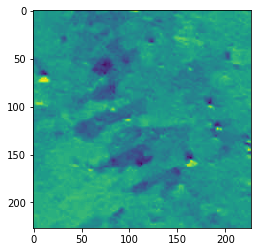

In [22]:
predict_image2('negative', 3001)       

Working On Predictable Data : positive

Images Processed from 01901 to 01902

Raw Predicted Label(Numeric): 1.0

Predicted Label : Crack


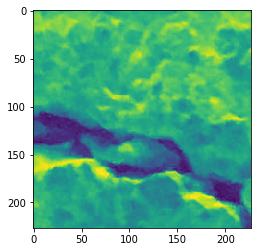

In [23]:
predict_image2('positive', 1901)       

Working On Predictable Data : positive

Images Processed from 01111 to 01112

Raw Predicted Label(Numeric): 1.0

Predicted Label : Crack


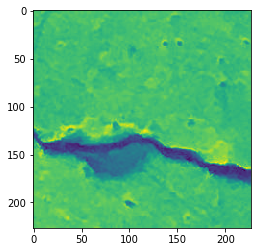

In [24]:
predict_image2('positive', 1111)       

Working On Predictable Data : negative

Images Processed from 09991 to 09992

Raw Predicted Label(Numeric): 1.6058257e-12

Predicted Label : No Crack


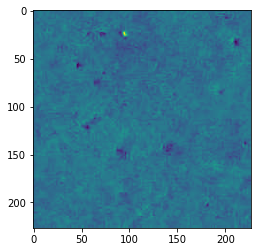

In [25]:
predict_image2('negative', 9991)       

#  Saving Model

In [26]:
model.save_weights('third_30_weights.h5')
model.save('third_30.h5')